## same as EXP2, the bottleneck model to tackle 250 products, but this time for dense assortment input. Train for more epoches. Sample amount is likely enough

In [25]:
import AssortmentGenerator as AG
import MarkovGenerator as MG
import Models
import time

import numpy as np
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

start_time = time.time()

N_prod = 250        # number of products
Vec_Len = N_prod + 1
Neck_Len = 30       # bottle neck width
# EPOCHS = 2000
EPOCHS = 1
SAMPLE_AMOUNT = 500000
BATCH_SIZE = 5000
TRAIN_VALI_RATE = 0.9
ADAM_LR = 0.0005

# generate latent parameters
transP = np.load("EXP7_dump/markov_matrix.npy")
lams = np.load("EXP7_dump/arriving_lambda.npy")

model = torch.load("EXP7_dump/bottleneck_model_3.pth")

# generate synthetic data
INPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
for i in range(SAMPLE_AMOUNT):
    
    # generate input vector, which has length vec_len
    # the first element is 0, which should be ignored when treated as an assortment
    assort = AG.GenAssortment_Abundant(N_prod)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)

print("data generated!")
print("total time elapse : ",time.time()-start_time)

train_dataset = TensorDataset(torch.Tensor(INPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]),torch.Tensor(OUTPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]))    
vali_dataset = TensorDataset(torch.Tensor(INPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]),torch.Tensor(OUTPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]))    

train_loader = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE)
vali_loader = DataLoader(vali_dataset, shuffle=True, batch_size = len(vali_dataset))

optimizer = optim.Adam(model.parameters(), lr = ADAM_LR)
criterion = nn.BCELoss()

training_losses = np.array([])
vali_losses = np.array([])

for epo in range(1,EPOCHS+1):
    if epo % 50 == 0:
        print("epoch : ",epo)
    for step, (IN, TEST) in enumerate(train_loader):
        
        OUT = model(IN)
        loss = criterion(OUT,TEST)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_pure = loss.detach().item()
        loss_base = criterion(TEST,TEST).detach().item()
        training_losses= np.append(training_losses,(loss_pure - loss_base)/loss_base)
        
    for step, (VALI_IN, VALI_TEST) in enumerate(vali_loader):
        VALI_OUT = model(VALI_IN)
        
        RELATIVE_LOSS = nn.functional.l1_loss(VALI_TEST, VALI_OUT, size_average=False, reduce = False, reduction = None) / torch.clamp(VALI_TEST, min = 1/Vec_Len)

        losses = torch.clamp(torch.reshape(RELATIVE_LOSS,(-1,)), max=4).detach().numpy()
        
        vali_losses = np.append(vali_losses,losses)

np.save('EXP7_dump/bottleneck_train_loss_Large', training_losses)
np.save('EXP7_dump/bottleneck_vali_loss_Large', vali_losses)
torch.save(model, "EXP7_dump/bottleneck_model_Large.pth")

data generated!
total time elapse :  401.1853349208832


D:\SOFTWARE\ANACONDA\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


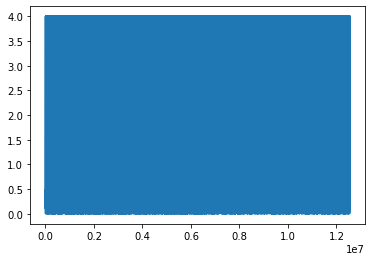

In [28]:
train_loss = np.load('EXP7_dump/bottleneck_vali_loss_LARGE.npy')
plt.plot(train_loss)